<a href="https://colab.research.google.com/github/nomppy/colab-notebooks/blob/main/Neural_Fields_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Neural Fields to Represent Image

In this colab, you are going to do a small coding exercise where you will train a neural network to represent an image.

In [1]:
!pip install imageio-ffmpeg
!pip install lovely-tensors
!pip install imageio
!pip install pandas

# TODO isntall what you need

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os, imageio
import numpy as np
import torch
lt.monkey_patch()

# TODO import what you need

# Data

Our data will be pairs of $(x, y)$, where $x\in \mathbb{R}^2$ parameterize the pixel location, and $y\in \mathbb{R}^3$ is the RGB.

In this section, we will write a pytorch dataloader to produce these pairs.

<ipython-input-3-134d0b79aeca>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


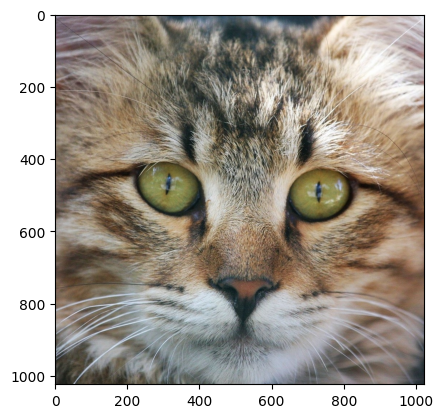

In [3]:
# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

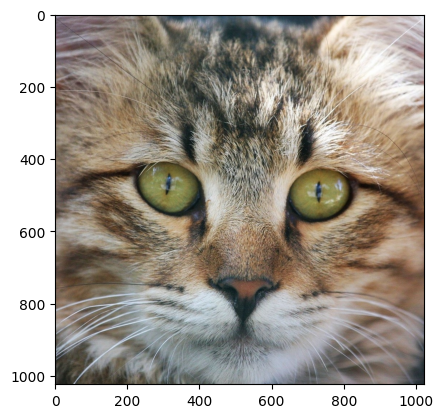

In [4]:
plt.imshow(torch.from_numpy(img).view(-1, 3).view(1024, 1024, 3))

In [5]:
import os
import pandas as pd
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

def get_img_tensor(img, sidelength):
    transform = Compose([
        ToTensor(),
        Resize(sidelength),
        # Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class CustomImageDataset(Dataset):
    def __init__(self, img, sidelength=1024):
        super().__init__()
        img = get_img_tensor(img, sidelength)
        self.X = get_mgrid(sidelength, 2) # TODO: (..., 2)
        self.Y = img.permute(1, 2, 0).view(-1, 3).float() # TODO: (..., 3)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# TODO test your dataset
dataset = CustomImageDataset(img, 1024)
print(dataset.X.shape)
print(dataset.Y.shape)
loader = DataLoader(dataset, batch_size=1024)
xy, rgb = next(iter(loader))
xy, rgb
print(rgb.type())
print(rgb)
print(xy.type())
print(xy)


torch.Size([1048576, 2])
torch.Size([1048576, 3])
torch.FloatTensor
tensor[1024, 3] n=3072 (12Kb) x∈[0.114, 0.933] μ=0.442 σ=0.213
torch.FloatTensor
tensor[1024, 2] n=2048 (8Kb) x∈[-1.000, 1.000] μ=-0.500 σ=0.646


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Network Architecture


Tips: you might find it useful to use Fourier positional encoding helpful! Check these papers:
1. https://arxiv.org/abs/2006.09661
2. https://arxiv.org/abs/2006.10739
3. https://arxiv.org/abs/2003.08934



### Sine

In [6]:
# https://colab.research.google.com/drive/1gSr_DzMSCO5eNriPS_9FCL2fSWSiruq3#scrollTo=bsW62jqilZYz
class SineActivation(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0

    def __repr__(self):
        return f'SineActivation(omega={self.omega_0})'

    def forward(self, input):
        return torch.sin(self.omega_0 * input)

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class SineNet(nn.Module):

  def __init__(self,
               inp_dim=2, out_dim=3, hid_dims=[128],
               first_omega_0=30,
               hidden_omega_0=30,
               **kwargs):
    super().__init__()
    layers = []

    curr_dim = inp_dim

    for dim in hid_dims:
      if curr_dim == inp_dim:
        layers.append(SineLayer(curr_dim, dim, is_first=True, omega_0=first_omega_0))
      else:
        layers.append(SineLayer(curr_dim, dim, is_first=False, omega_0=hidden_omega_0))
      curr_dim = dim

    final_linear = nn.Linear(curr_dim, out_dim)
    with torch.no_grad():
        final_linear.weight.uniform_(-np.sqrt(6 / curr_dim) / hidden_omega_0,
                                      np.sqrt(6 / curr_dim) / hidden_omega_0)

    layers.append(final_linear)

    self.net = nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)

In [7]:
torch.ones((64, 2)).unsqueeze(-1) * torch.pow(2.0, torch.linspace(0.0, 10 - 1, 10))

tensor[64, 2, 10] n=1280 (5Kb) x∈[1.000, 512.000] μ=102.300 σ=156.545

### pos encoding

In [8]:
std = 10
freqs = 128
B = torch.randn((2, freqs)) * std

L = 10

def pos_enc(x, *args, **kwargs):
  if len(x.shape) == 1:
    x = x.unsqueeze(0)

  # From [batchsize, xdim] to [batchsize, freqs]
  x = 2 * np.pi * (x @ B)

  # Positional encoding using sin and cos functions, [batchsize, freqs*2]
  enc = torch.cat([torch.cos(x),
                  torch.sin(x)], dim=1)
  return enc

# from nerf paper
def nerf_pos_enc(x, freqs=10, *args, **kwargs):
  if len(x.shape) == 1:
    x = x.unsqueeze(0)

  B, C = x.shape

  pi = torch.Tensor([np.pi])
  # (L)
  angles = torch.pow(2, torch.arange(0, freqs, 1)) * pi
  angles = angles.cuda()

  # (B, C) -> (B, C, 1)
  x = x.unsqueeze(-1)

  enc = torch.cat([torch.sin(x * angles), torch.cos(x * angles)], dim=1)
  return enc.view(B, -1)


### basic net (non sinuisoidal activation) definitions

In [9]:
class Net(nn.Module):
    def __init__(self,
                 inp_dim=2,
                 out_dim=3,
                 hid_dims=[128],
                 activation='leakyrelu',
                 **kwargs):
        super().__init__()
        layers = []

        act = self.get_activation(activation)

        curr_dim = inp_dim
        for dim in hid_dims:
            layers.append(nn.Linear(curr_dim, dim))
            layers.append(act)
            curr_dim = dim

        final_linear = nn.Linear(curr_dim, out_dim)
        layers.append(final_linear)

        self.net = nn.Sequential(*layers)

    def get_activation(self, activation, omega=0):
      if activation == 'sine':
        return SineActivation(omega)

      activations = nn.ModuleDict({
          'relu': nn.ReLU(),
          'leakyrelu': nn.LeakyReLU(),
      })
      return activations[activation]

    def forward(self, x):
        return self.net(x)

class InitializedNet(nn.Module):

  def __init__(self,
               inp_dim=2, out_dim=3, hid_dims=[128],
               activation='relu',
               first_omega_0=30,
               hidden_omega_0=30,
               **kwargs):
    super().__init__()
    layers = []

    curr_dim = inp_dim

    for dim in hid_dims:
      linear = nn.Linear(curr_dim, dim)
      with torch.no_grad():
        if curr_dim == inp_dim:
          linear.weight.uniform_(-1 / inp_dim,
                                   1 / inp_dim)
          act = self.get_activation(activation, first_omega_0)
        else:
          linear.weight.uniform_(-np.sqrt(6 / curr_dim) / hidden_omega_0,
                                np.sqrt(6 / curr_dim) / hidden_omega_0)
          act = self.get_activation(activation, hidden_omega_0)

      layers.append(linear)
      layers.append(act)
      curr_dim = dim

    final_linear = nn.Linear(curr_dim, out_dim)
    with torch.no_grad():
        final_linear.weight.uniform_(-np.sqrt(6 / curr_dim) / hidden_omega_0,
                                      np.sqrt(6 / curr_dim) / hidden_omega_0)

    layers.append(final_linear)

    self.net = nn.Sequential(*layers)


  def forward(self, x):
    return self.net(x)

In [10]:
# Test your architecture
net = Net(2, 3, [256, 256, 256, 256], 'leakyrelu').cuda()
batch_size = 1234
net(torch.ones((batch_size, 2)).cuda())

tensor[1234, 3] n=3702 (14Kb) x∈[-0.003, 0.030] μ=0.018 σ=0.015 grad AddmmBackward0 cuda:0

In [11]:
net

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)


# Testing

In [12]:
def create_image(model, resolution):
  input = get_mgrid(resolution, 2).cuda()
  rgb = model(input)
  rgb = rgb.reshape(resolution, resolution, 3)
  return rgb.detach().cpu().numpy()

In [13]:
def compute_psnr(out, gt):
  mse = torch.mean((out - gt) ** 2)
  psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
  return psnr

In [14]:
# Preparing training, (e.g. initialize optimizer ...)

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
dataset = CustomImageDataset(img, 1024)
loader = DataLoader(dataset, batch_size=64,
                    shuffle=True, pin_memory=True, num_workers=0)

total_steps = 10000
summary_steps = 100
freqs = 6
fnet = SineNet(2, 3, [256, 256, 256, 256])
fnet.forward = lambda x: fnet(nerf_pos_enc(x, freqs))
fnet.cuda()

opt = torch.optim.Adam(lr=1e-3, params=fnet.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)
data_iter = iter(loader)

loss_list = []
for i in range(total_steps):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)
  x, y = x.cuda(), y.cuda()

  opt.zero_grad()
  out = fnet(x)
  loss = nn.MSELoss()(out, y)
  with torch.no_grad():
      loss_list.append(loss.item())
      if i % summary_steps == 0:
        print(f'Step {i}, total loss {loss.item()}, psnr {compute_psnr(y,out.detach())}')

  loss.backward()
  opt.step()
  scheduler.step()

  # TODO: monitor the training.
plt.plot(loss_list)
plt.show()

<ipython-input-14-af0f4b1f3cdd>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.54 GiB. GPU 0 has a total capacity of 14.75 GiB of which 4.50 GiB is free. Process 42942 has 10.24 GiB memory in use. Of the allocated memory 10.12 GiB is allocated by PyTorch, and 5.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### With fourier enc

In [ ]:
# Preparing training, (e.g. initialize optimizer ...)

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
dataset = CustomImageDataset(img, 1024)
loader = DataLoader(dataset, batch_size=256,
                    shuffle=True, pin_memory=True, num_workers=0)

total_steps = 10000
summary_steps = 100
freqs = 10
fnet = Net(2, 3, [256, 256, 256, 256], 'relu', freqs=freqs)
fnet.forward = lambda x: fnet(pos_enc(x))
fnet.cuda()

opt = torch.optim.Adam(lr=1e-3, params=fnet.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)
data_iter = iter(loader)

loss_list = []
for i in range(total_steps):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)
  x, y = x.cuda(), y.cuda()

  opt.zero_grad()
  out = fnet(x)
  loss = nn.MSELoss()(out, y)
  with torch.no_grad():
      loss_list.append(loss.item())
      if i % summary_steps == 0:
        print(f'Step {i}, total loss {loss.item()}, psnr {compute_psnr(y,out.detach())}')

  loss.backward()
  opt.step()
  scheduler.step()

  # TODO: monitor the training.
plt.plot(loss_list)
plt.show()

<ipython-input-12-3ffad06d745f>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

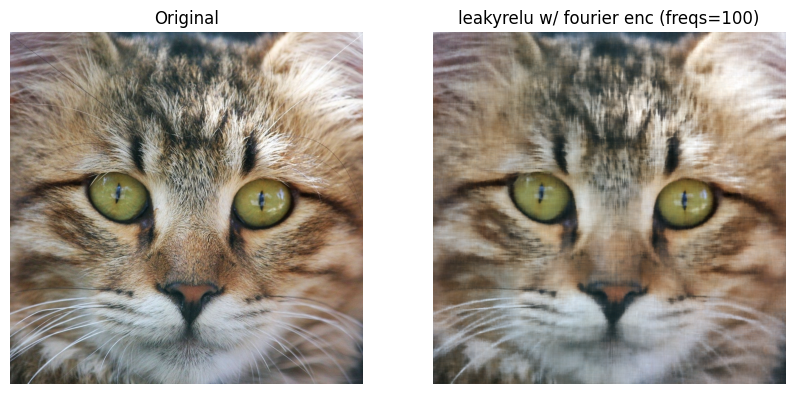

In [ ]:
fig, (org, inr) = plt.subplots(1, 2, figsize=(10,5))
org.imshow(img)
org.set_title('Original')
org.axis('off')
inr.imshow(create_image(fnet, 1024))
inr.set_title(f'leakyrelu w/ fourier enc (freqs={freqs})')
inr.axis('off')

plt.show()

### With leakyrelu




<ipython-input-25-658c4c3fce6c>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


Step 0, total loss 0.32592421770095825
Step 100, total loss 0.027815891429781914
Step 200, total loss 0.02461680769920349
Step 300, total loss 0.023044457659125328
Step 400, total loss 0.023252887651324272
Step 500, total loss 0.024107906967401505
Step 600, total loss 0.02257663570344448
Step 700, total loss 0.020874712616205215
Step 800, total loss 0.020283449441194534
Step 900, total loss 0.02027861773967743
Step 1000, total loss 0.019644174724817276
Step 1100, total loss 0.017948856577277184
Step 1200, total loss 0.017915623262524605
Step 1300, total loss 0.019314002245664597
Step 1400, total loss 0.01564955711364746
Step 1500, total loss 0.017880048602819443
Step 1600, total loss 0.015896998345851898
Step 1700, total loss 0.01698172464966774
Step 1800, total loss 0.018367944285273552
Step 1900, total loss 0.014386187307536602
Step 2000, total loss 0.016307126730680466
Step 2100, total loss 0.0162203349173069
Step 2200, total loss 0.016251815482974052
Step 2300, total loss 0.0141558

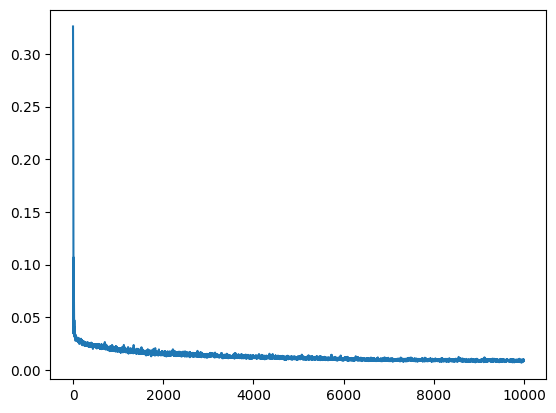

In [ ]:
# Preparing training, (e.g. initialize optimizer ...)
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
dataset = CustomImageDataset(img, 1024)
loader = DataLoader(dataset, batch_size=1024,
                    shuffle=True, pin_memory=True, num_workers=0)

net = Net(2, 3, [256, 256, 256, 256], 'leakyrelu')
net.cuda()

total_steps = 10000
summary_steps = 100

opt = torch.optim.Adam(lr=1e-3, params=net.parameters())

data_iter = iter(loader)

loss_list = []
for i in range(total_steps):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)
  x, y = x.cuda(), y.cuda()

  opt.zero_grad()
  out = net(x)
  loss = nn.MSELoss()(out, y)
  with torch.no_grad():
      loss_list.append(loss.item())
      if i % summary_steps == 0:
        print(f'Step {i}, total loss {loss.item()}')

  loss.backward()
  opt.step()

  # TODO: monitor the training.
plt.plot(loss_list)
plt.show()

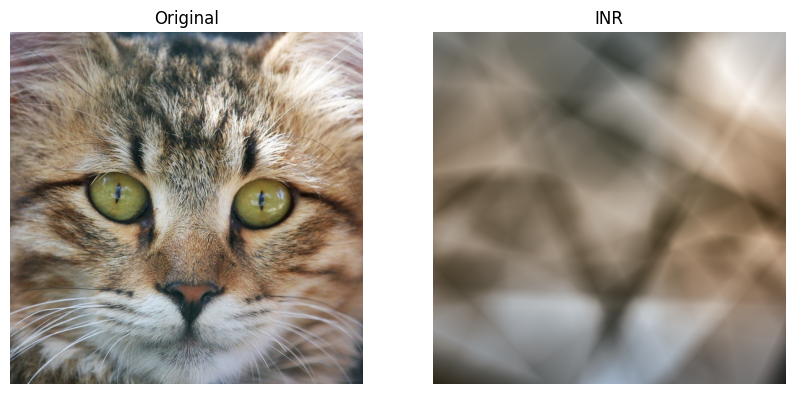

In [ ]:
fig, (org, inr) = plt.subplots(1, 2, figsize=(10,5))
org.imshow(img)
org.set_title('Original')
org.axis('off')
inr.imshow(create_image(net, 1024))
inr.set_title('LeakyRelu')
inr.axis('off')

plt.show()

### With sinuisoidal activations

<ipython-input-117-7677ffb34bfd>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


Step 0, total loss 0.2746344804763794, psnr 5.612449645996094
Step 50, total loss 0.009654058143496513, psnr 20.152902603149414
Step 100, total loss 0.008060099557042122, psnr 20.936595916748047
Step 150, total loss 0.0077207861468195915, psnr 21.12338638305664
Step 200, total loss 0.007050509564578533, psnr 21.517793655395508
Step 250, total loss 0.00690050795674324, psnr 21.611190795898438
Step 300, total loss 0.005935351364314556, psnr 22.26553726196289
Step 350, total loss 0.00602209335193038, psnr 22.202526092529297
Step 400, total loss 0.006074638105928898, psnr 22.164798736572266
Step 450, total loss 0.006315513513982296, psnr 21.995914459228516
Step 500, total loss 0.005873104557394981, psnr 22.311323165893555
Step 550, total loss 0.006042499095201492, psnr 22.187835693359375
Step 600, total loss 0.006688437890261412, psnr 21.74675178527832
Step 650, total loss 0.006319764070212841, psnr 21.992992401123047
Step 700, total loss 0.005889818072319031, psnr 22.298982620239258
Step 

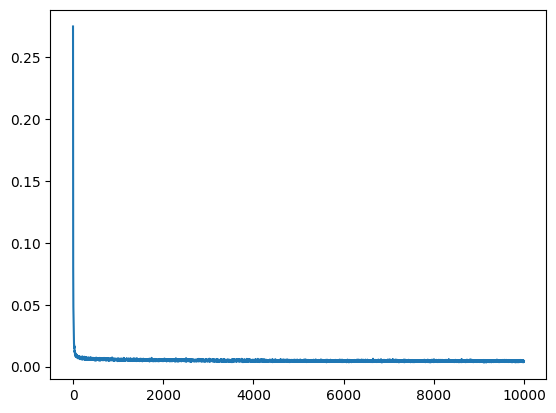

In [ ]:
# Preparing training, (e.g. initialize optimizer ...)
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
dataset = CustomImageDataset(img, 1024)
loader = DataLoader(dataset, batch_size=1024,
                    shuffle=True, pin_memory=True, num_workers=0)

snet = SineNet(2, 3, [256, 256, 256, 256])
# net = Siren(in_features=2, out_features=3, hidden_features=256,
#                   hidden_layers=3, outermost_linear=True)
snet.cuda()

total_steps = 10000
summary_steps = 50

opt = torch.optim.Adam(lr=1e-4, params=snet.parameters())

data_iter = iter(loader)

loss_list = []
for i in range(total_steps):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)
  x, y = x.cuda(), y.cuda()

  opt.zero_grad()
  out = snet(x)
  loss = nn.MSELoss()(out, y)
  with torch.no_grad():
      loss_list.append(loss.item())
      if i % summary_steps == 0:
        print(f'Step {i}, total loss {loss.item()}, psnr {compute_psnr(y,out.detach())}')


  loss.backward()
  opt.step()

  # TODO: monitor the training.
plt.plot(loss_list)
plt.show()

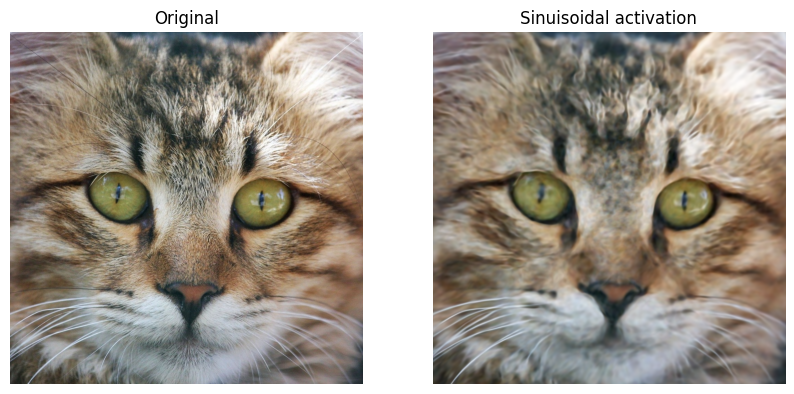

In [ ]:
fig, (org, inr) = plt.subplots(1, 2, figsize=(10,5))
org.imshow(img)
org.set_title('Original')
org.axis('off')
inr.imshow(create_image(snet, 1024))
inr.set_title('Sinuisoidal activation')
inr.axis('off')

plt.show()

# Further Testing

In [ ]:
out_img = create_image(1024*8)
plt.imshow(out_img)
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 GiB. GPU 0 has a total capacity of 14.75 GiB of which 13.57 GiB is free. Process 3019 has 1.17 GiB memory in use. Of the allocated memory 541.75 MiB is allocated by PyTorch, and 526.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Some open questions

- Does the network know the face is symmetry?
- What would you do to enforce the network outputs symmetry signals?